In [8]:
import gzip
import json
import re
import os
import sys
import timeit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
from collections import defaultdict
import tensorflow as tf
import altair as alt
import collections

from src.utils import split_dataframe, CFModel
from src.load_data import read_tables
from src.DNN_Model import generate_dataset, build_dnn_model, make_shared_embedding_col, make_embedding_col

### load reviews and books data

In [3]:
reviews = pd.read_csv('data/cleaned_reviews_mystery_1.csv')
books = pd.read_csv('data/cleaned_books_mystery_1.csv')

In [4]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1551765 entries, 0 to 1551764
Data columns (total 9 columns):
review_id      1551765 non-null object
user_id        1551765 non-null int64
book_id        1551765 non-null int64
rating         1551765 non-null int64
timestamp      1551765 non-null object
n_votes        1551765 non-null int64
n_comments     1551765 non-null int64
old_user_id    1551765 non-null object
old_book_id    1551765 non-null int64
dtypes: int64(6), object(3)
memory usage: 106.6+ MB


In [29]:
reviews.head(2)

,review_id,user_id,book_id,rating,timestamp,n_votes,n_comments,old_user_id,old_book_id
0,d23dc89ab32cd864e54d18369751163b,102489,37120,3,2001-01-01 00:00:00,0,0,d889b42d9eb7b80e02f24830e27c6389,196084
1,c7613da4cbd48baa83efec99b4dd6a41,102489,96299,3,2001-01-11 00:00:00,0,0,d889b42d9eb7b80e02f24830e27c6389,79030


In [5]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105365 entries, 0 to 105364
Data columns (total 12 columns):
book_id               105365 non-null int64
title                 105365 non-null object
num_pages             105365 non-null int64
is_ebook              105365 non-null int64
link                  105365 non-null object
average_rating        105365 non-null float64
ratings_count         105365 non-null int64
text_reviews_count    105365 non-null int64
author_id             105365 non-null int64
publisher             76004 non-null object
similar_books         105365 non-null object
old_book_id           105365 non-null int64
dtypes: float64(1), int64(7), object(4)
memory usage: 9.6+ MB


In [30]:
books.head(2)

,book_id,title,num_pages,is_ebook,link,average_rating,ratings_count,text_reviews_count,author_id,publisher,similar_books,old_book_id
0,75512,The House of Memory (Pluto's Snitch #2),318,1,https://www.goodreads.com/book/show/33394837-t...,4.33,269,60,242185,NaN,[],33394837
1,35550,"Dead in the Morning (Patrick Grant, #1)",0,0,https://www.goodreads.com/book/show/1902202.De...,3.3,52,8,190988,Ulverscroft,[],1902202


### generate data for dnn model

input layer: previously liked book, previously disliked book, book content features (here only include 'author_id')

In [6]:
# one-time code to generate dataset for dnn model, then save to pickle file

# dataset = generate_dataset(reviews, books, min_good_rating =4, max_num_books_per_user=20) # processed 1551000 rows
#dataset.to_pickle('data/dnn_dataset_w_books.pkl')

 processed 1551000 rows 

In [3]:
# read saved dnn-ready data

dataset = pd.read_pickle('data/dnn_dataset_w_books.pkl')

In [4]:
dataset.tail(2)

,user_id,book_id,rating,timestamp,author_id,prev_good_books,prev_bad_books
1551763,34243,78523,5,2017-11-03 21:12:55,202905,"[55927, 47953, 44562, 61742, 68857, 55357, 606...",[]
1551764,71677,82113,3,2017-11-03 22:17:08,3936,"[46538, 83396, 13821]",[22731]


### build model

In [10]:
#constraint to two previously liked and disliked books to speed up iteration

dataset['prev_good_books'] = dataset['prev_good_books'].apply(lambda x: x[:2])
dataset['prev_bad_books'] = dataset['prev_bad_books'].apply(lambda x: x[:2])

 iteration 10000: train_loss=2.825915, test_loss=6.460485
time spent for the process is 347.25079


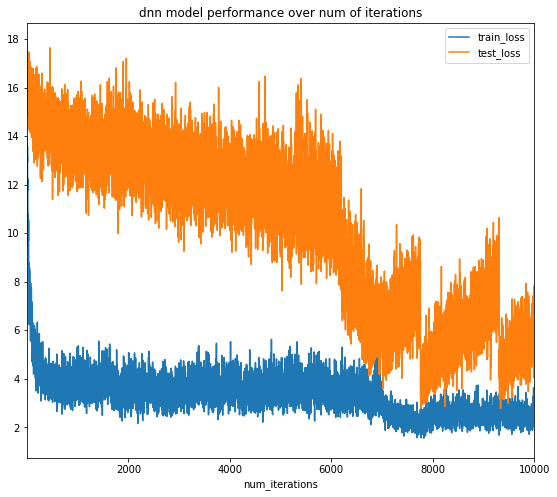

In [28]:
with tf.Graph().as_default():
    print('embedding_cols start')
    embedding_cols = make_shared_embedding_col(
                ['prev_good_books','prev_bad_books'],
                'book_id_embedding',
                list(dataset['book_id'].unique()), 5) + [
            make_embedding_col('author_id',list(dataset['author_id'].unique()), 5)] #input features should be string to create embedding
             #make_embedding_col('publisher',10)
        
    print('embedding_cols done')
    dnn_model = build_dnn_model(dataset,
        embedding_cols = embedding_cols, hidden_dims=[5],
        learning_rate = 0.1
    )
    
start_time = timeit.default_timer()
dnn_model.train( num_iterations =10000)
print('\ntime spent for the process is %.5f seconds'% (timeit.default_timer() - start_time))

In [4]:
# constraint to 5 previously liked and disliked books

dataset['prev_good_books'] = dataset['prev_good_books'].apply(lambda x: x[:5])
dataset['prev_bad_books'] = dataset['prev_bad_books'].apply(lambda x: x[:5])

In [6]:
start_time = timeit.default_timer()
with tf.Graph().as_default():
    print('embedding_cols start')
    embedding_cols = make_shared_embedding_col(
                ['prev_good_books','prev_bad_books'],
                'book_id_embedding',
                list(dataset['book_id'].unique()), 5) + [
            make_embedding_col('author_id',list(dataset['author_id'].unique()), 5)] #input features should be string to create embedding
             #make_embedding_col('publisher',10)
        
    print('embedding_cols done')
    dnn_model = build_dnn_model(dataset,
        embedding_cols = embedding_cols, hidden_dims=[5],
        learning_rate = 0.1
    )
    
print('\ntime spent for the process is %.5f seconds'% (timeit.default_timer() - start_time))

embedding_cols start
embedding_cols done
build_dnn_model#1 create_network
build_dnn_model#2 split train_test dataset
train_data mean rating: 3.80621
make_batch#3
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
make_batch#4
make_batch#3
make_batch#4
build_dnn_model#3


Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
The old _FeatureColumn APIs are bei

 iteration 10000: train_loss=2.588658, test_loss=6.588341
time spent for the process is 573.90401 seconds


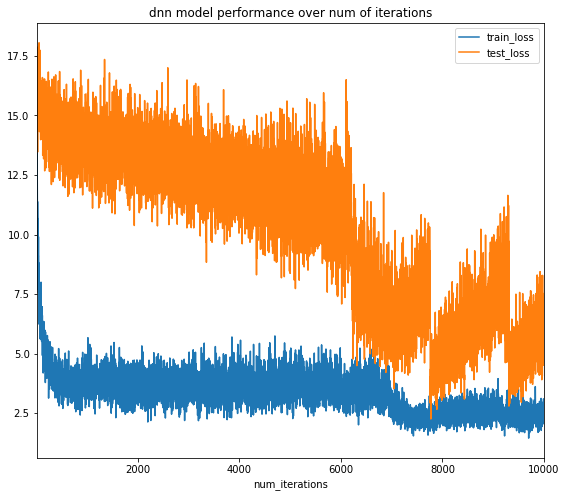

In [7]:
start_time = timeit.default_timer()
dnn_model.train( num_iterations =10000)
print('\ntime spent for the process is %.5f seconds'% (timeit.default_timer() - start_time))